In [1]:
!pip install openmim
!mim install mmdet

  Using cached openmim-0.1.5-py2.py3-none-any.whl
  Using cached click-7.1.2-py2.py3-none-any.whl (82 kB)
  Using cached model_index-0.1.11-py3-none-any.whl (34 kB)
  Using cached tabulate-0.8.9-py3-none-any.whl (25 kB)
  Using cached pandas-1.3.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.3 MB)
  Using cached colorama-0.4.4-py2.py3-none-any.whl (16 kB)
  Using cached PyYAML-6.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (596 kB)
  Using cached ordered_set-4.1.0-py3-none-any.whl (7.6 kB)
  Using cached Markdown-3.3.6-py3-none-any.whl (97 kB)
installing mmdet from https://github.com/open-mmlab/mmdetection.git.
Cloning into '/tmp/.u3568315/tmp0nour8xq/mmdetection'...
remote: Enumerating objects: 23411, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 23411 (delta 0), reused 1 (delta 0), pack-reused 23410
Receiving objects: 100% (23411/23411), 26.03 MiB | 9.85 MiB/s, done.
Resolving deltas: 100% (16369

In [3]:
# download KITTI images
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip

--2022-02-26 18:37:52--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.170.65
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.170.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12569945557 (12G) [application/zip]
Saving to: ‘data_object_image_2.zip’

data_object_image_2 100%[===================>]  11.71G  14.9MB/s    in 19m 25s 

2022-02-26 18:57:21 (10.3 MB/s) - ‘data_object_image_2.zip’ saved [12569945557/12569945557]



In [4]:
# download labels
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip

--2022-02-26 18:57:21--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.170.41
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.170.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5601213 (5.3M) [application/zip]
Saving to: ‘data_object_label_2.zip’

data_object_label_2 100%[===================>]   5.34M  3.56MB/s    in 1.5s    

2022-02-26 18:57:25 (3.56 MB/s) - ‘data_object_label_2.zip’ saved [5601213/5601213]



In [1]:
%cd mmdetection

/userhome/cs/u3568315/Project/mmdetection


In [ ]:
!unzip data_object_image_2.zip 

Archive:  data_object_image_2.zip
   creating: training/image_2/
 extracting: training/image_2/002480.png  
 extracting: training/image_2/005952.png  
 extracting: training/image_2/000709.png  
 extracting: training/image_2/000814.png  
 extracting: training/image_2/006192.png  
 extracting: training/image_2/006017.png  
 extracting: training/image_2/002731.png  
 extracting: training/image_2/005295.png  
 extracting: training/image_2/005347.png  
 extracting: training/image_2/005326.png  
 extracting: training/image_2/005713.png  
 extracting: training/image_2/007000.png  
 extracting: training/image_2/004353.png  
 extracting: training/image_2/003969.png  
 extracting: training/image_2/001973.png  
 extracting: training/image_2/001440.png  
 extracting: training/image_2/007083.png  
 extracting: training/image_2/000166.png  
 extracting: training/image_2/004479.png  
 extracting: training/image_2/003732.png  
 extracting: training/image_2/003998.png  
 extracting: training/image_2/00

In [ ]:
!unzip data_object_label_2.zip

In [15]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.dataset_wrappers import RepeatDataset
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module(force=True)
class KittiFullDataset(CustomDataset):

    
    # def __init__(self, times, dataset, pipeline, *args, **kwargs):
        # super().__init__(times=times, dataset=dataset)
        # self.times = times
        # self.dataset = self.KittyInner(pipeline, *args, **kwargs)
        # print(times, dataset)
        
# class KittyInner(CustomDataset):
    CLASSES = ('Car', 'Pedestrian', 'Cyclist')
    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)

        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.png'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]

            data_info = dict(filename=f'{image_id}.png', width=width, height=height)

            # load annotations
            label_prefix = self.img_prefix.replace('image_2', 'label_2')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))

            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]

            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []

            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

In [3]:
1+1

2

In [7]:
!ls ../faster_rcnn/checkpoints

faster_rcnn_r50_fpn_rsb-pretrain_1x_coco_20220113_162229-32ae82a9.pth
faster_rcnn_x101_32x4d_fpn_mstrain_3x_coco_20210524_124151-16b9b260.pth
faster_rcnn_x101_64x4d_fpn_mstrain_3x_coco_20210524_124528-26c63de6.pth
rpn_r50_fpn_1x_coco_20200218-5525fa2e.pth


In [21]:
!wget https://download.openmmlab.com/mmdetection/v2.0/tood/tood_r101_fpn_dconv_c3-c5_mstrain_2x_coco/tood_r101_fpn_dconv_c3-c5_mstrain_2x_coco_20211210_213728-4a824142.pth \
 -O ../tood/tood_r101_fpn_dconv_c3-c5_mstrain_2x_coco_20211210_213728-4a824142.pth

--2022-03-07 19:32:39--  https://download.openmmlab.com/mmdetection/v2.0/tood/tood_r101_fpn_dconv_c3-c5_mstrain_2x_coco/tood_r101_fpn_dconv_c3-c5_mstrain_2x_coco_20211210_213728-4a824142.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.18
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 215053881 (205M) [application/octet-stream]
Saving to: ‘../tood/tood_r101_fpn_dconv_c3-c5_mstrain_2x_coco_20211210_213728-4a824142.pth’

../tood/tood_r101_f 100%[===================>] 205.09M  8.80MB/s    in 22s     

2022-03-07 19:33:01 (9.41 MB/s) - ‘../tood/tood_r101_fpn_dconv_c3-c5_mstrain_2x_coco_20211210_213728-4a824142.pth’ saved [215053881/215053881]



In [5]:
!git clone https://github.com/open-mmlab/mmdetection.git

Cloning into 'mmdetection'...
remote: Enumerating objects: 23411, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 23411 (delta 0), reused 1 (delta 0), pack-reused 23410
Receiving objects: 100% (23411/23411), 26.03 MiB | 8.78 MiB/s, done.
Resolving deltas: 100% (16360/16360), done.
Checking out files: 100% (1382/1382), done.


In [1]:
!pwd

/userhome/cs/u3568315/Project


In [1]:
%cd mmdetection

/userhome/cs/u3568315/Project/mmdetection


In [23]:
import random
random.seed(10)

kitti_dir = "kitti_full/"
# total_num = 7481
total_num = 1000  # previous 200
number_seq = list(range(7000))
random.shuffle(number_seq)
t_ratio = 7
v_ratio = 3

train_num = int(total_num *t_ratio/(t_ratio+v_ratio))
print(train_num)
current_num = 0
with open(kitti_dir+"train.txt", 'w') as f:
    while current_num < train_num:
    # print(f"{current_num:06}")
        f.write(f"{number_seq[current_num]:06}\n")
        current_num += 1
print("---")
with open(kitti_dir+"val.txt", 'w') as f:
    while current_num < total_num:
    # print(f"{current_num:06}")
        f.write(f"{number_seq[current_num]:06}\n")
        current_num += 1
print(current_num == total_num)

700
---
True


In [ ]:
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_x101_64x4d_fpn_1x_coco.py')
print(f'Config:\n{cfg.pretty_text}')

In [2]:
from mmcv import Config
base_cfg_path = "./configs/rpn/rpn_r50_fpn_1x_coco.py"
cfg = Config.fromfile(base_cfg_path)
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='RPN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1

In [7]:
1+1

2

In [6]:
from mmcv import Config
cfg = Config.fromfile(base_cfg_path)
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNeXt',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(
            type='Pretrained', checkpoint='open-mmlab://resnext101_64x4d'),
        groups=64,
        base_width=4),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict

In [4]:
from mmcv import Config

base_cfg_path = "./configs/resnet_strikes_back/faster_rcnn_r50_fpn_rsb-pretrain_1x_coco.py"
# base_checkpoint = "../faster_rcnn/checkpoints/faster_rcnn_r50_fpn_rsb-pretrain_1x_coco_20220113_162229-32ae82a9.pth"
base_checkpoint = "./strikes_back/latest.pth"
working_dir = './strikes_back'

cfg = Config.fromfile(base_cfg_path)
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(
            type='Pretrained',
            checkpoint=
            'https://download.openmmlab.com/mmclassification/v0/resnet/resnet50_8xb256-rsb-a1-600e_in1k_20211228-20e21305.pth',
            prefix='backbone.')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target

In [5]:

# print(f'Config:\n{cfg.pretty_text}')
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'KittiFullDataset'
cfg.data_root = 'kitti_full/'

cfg.data.test.type = 'KittiFullDataset'
cfg.data.test.data_root = 'kitti_full/'
cfg.data.test.ann_file = 'val.txt'
cfg.data.test.img_prefix = 'training/image_2'

cfg.data.train.type = 'KittiFullDataset'
cfg.data.train.data_root = 'kitti_full/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittiFullDataset'
cfg.data.val.data_root = 'kitti_full/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 3
# cfg.model.bbox_head.num_classes = 3
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = base_checkpoint

# Set up working dir to save files and logs.
cfg.work_dir = working_dir

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.0002 / 4
cfg.lr_config.warmup = None
cfg.log_config.interval = 25
# cfg.lr_config.step = [8, 11]
# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12
cfg.runner.max_epochs = 12

# cfg.train_pipeline[2].flip_ratio = (1000
# cfg.data.train.pipeline[2].flip_ratio = 0.4

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# cfg.runner.max_epochs = 50
# cfg.lr_config.step = [38, 46]

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(
            type='Pretrained',
            checkpoint=
            'https://download.openmmlab.com/mmclassification/v0/resnet/resnet50_8xb256-rsb-a1-600e_in1k_20211228-20e21305.pth',
            prefix='backbone.')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target

In [45]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/userhome/cs/u3568315/anaconda3/envs/comp3340_project/lib/python3.7/site-packages/ipykernel_launcher.py:61: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/userhome/cs/u3568315/anaconda3/envs/comp3340_project/lib/python3.7/site-packages/ipykernel_launcher.py:64: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 420/420, 21.3 task/s, elapsed: 20s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-04-05 00:34:07,487 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1383 | 5691 | 0.953  | 0.875 |
| Pedestrian | 545  | 2940 | 0.851  | 0.650 |
| Cyclist    | 245  | 1966 | 0.931  | 0.768 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.765 |
+------------+------+------+--------+-------+
2022-04-05 00:34:07,492 - mmdet - INFO - Epoch(val) [1][420]	AP50: 0.7650, mAP: 0.7645
2022-04-05 00:34:14,774 - mmdet - INFO - Epoch [2][25/490]	lr: 5.000e-05, eta: 0:17:30, time: 0.291, data_time: 0.095, memory: 4367, loss_rpn_cls: 0.0138, loss_rpn_bbox: 0.0226, loss_cls: 0.1715, acc: 93.9102, loss_bbox: 0.2756, loss: 0.4836
2022-04-05 00:34:19,667 - mmdet - INFO - Epoch [2][50/490]	lr: 5.000e-05, eta: 0:17:25, time: 0.196, data_time: 0.005, memory: 4367, loss_rpn_cls: 0.0112, loss_rpn_bbox: 0.0209, loss_cls: 0.1693, acc: 93.4492, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 420/420, 20.3 task/s, elapsed: 21s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-04-05 00:36:07,217 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1383 | 4147 | 0.949  | 0.890 |
| Pedestrian | 545  | 2564 | 0.850  | 0.676 |
| Cyclist    | 245  | 1217 | 0.943  | 0.807 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.791 |
+------------+------+------+--------+-------+
2022-04-05 00:36:07,223 - mmdet - INFO - Epoch(val) [2][420]	AP50: 0.7910, mAP: 0.7912
2022-04-05 00:36:14,407 - mmdet - INFO - Epoch [3][25/490]	lr: 5.000e-05, eta: 0:15:53, time: 0.287, data_time: 0.095, memory: 4367, loss_rpn_cls: 0.0114, loss_rpn_bbox: 0.0255, loss_cls: 0.1602, acc: 94.1602, loss_bbox: 0.2961, loss: 0.4932
2022-04-05 00:36:19,221 - mmdet - INFO - Epoch [3][50/490]	lr: 5.000e-05, eta: 0:15:47, time: 0.193, data_time: 0.004, memory: 4367, loss_rpn_cls: 0.0084, loss_rpn_bbox: 0.0198, loss_cls: 0.1402, acc: 94.5508, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 420/420, 21.2 task/s, elapsed: 20s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-04-05 00:38:04,669 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1383 | 4426 | 0.961  | 0.909 |
| Pedestrian | 545  | 2799 | 0.892  | 0.730 |
| Cyclist    | 245  | 1228 | 0.943  | 0.858 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.833 |
+------------+------+------+--------+-------+
2022-04-05 00:38:04,674 - mmdet - INFO - Epoch(val) [3][420]	AP50: 0.8330, mAP: 0.8326
2022-04-05 00:38:11,951 - mmdet - INFO - Epoch [4][25/490]	lr: 5.000e-05, eta: 0:14:13, time: 0.290, data_time: 0.095, memory: 4368, loss_rpn_cls: 0.0093, loss_rpn_bbox: 0.0220, loss_cls: 0.1404, acc: 94.4258, loss_bbox: 0.2750, loss: 0.4466
2022-04-05 00:38:16,776 - mmdet - INFO - Epoch [4][50/490]	lr: 5.000e-05, eta: 0:14:08, time: 0.193, data_time: 0.005, memory: 4368, loss_rpn_cls: 0.0088, loss_rpn_bbox: 0.0186, loss_cls: 0.1240, acc: 95.1133, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 420/420, 19.8 task/s, elapsed: 21s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-04-05 00:40:03,810 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1383 | 3260 | 0.954  | 0.907 |
| Pedestrian | 545  | 4035 | 0.906  | 0.752 |
| Cyclist    | 245  | 702  | 0.951  | 0.871 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.843 |
+------------+------+------+--------+-------+
2022-04-05 00:40:03,815 - mmdet - INFO - Epoch(val) [4][420]	AP50: 0.8430, mAP: 0.8433
2022-04-05 00:40:11,353 - mmdet - INFO - Epoch [5][25/490]	lr: 5.000e-05, eta: 0:12:37, time: 0.301, data_time: 0.095, memory: 4368, loss_rpn_cls: 0.0051, loss_rpn_bbox: 0.0173, loss_cls: 0.1004, acc: 96.0625, loss_bbox: 0.1917, loss: 0.3145
2022-04-05 00:40:16,244 - mmdet - INFO - Epoch [5][50/490]	lr: 5.000e-05, eta: 0:12:32, time: 0.196, data_time: 0.005, memory: 4368, loss_rpn_cls: 0.0093, loss_rpn_bbox: 0.0230, loss_cls: 0.1339, acc: 94.6406, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 420/420, 20.3 task/s, elapsed: 21s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-04-05 00:42:02,723 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1383 | 3109 | 0.952  | 0.909 |
| Pedestrian | 545  | 2392 | 0.894  | 0.756 |
| Cyclist    | 245  | 887  | 0.963  | 0.885 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.850 |
+------------+------+------+--------+-------+
2022-04-05 00:42:02,729 - mmdet - INFO - Epoch(val) [5][420]	AP50: 0.8500, mAP: 0.8500
2022-04-05 00:42:09,880 - mmdet - INFO - Epoch [6][25/490]	lr: 5.000e-05, eta: 0:11:00, time: 0.285, data_time: 0.095, memory: 4368, loss_rpn_cls: 0.0047, loss_rpn_bbox: 0.0177, loss_cls: 0.1203, acc: 95.2656, loss_bbox: 0.2280, loss: 0.3707
2022-04-05 00:42:14,767 - mmdet - INFO - Epoch [6][50/490]	lr: 5.000e-05, eta: 0:10:56, time: 0.196, data_time: 0.005, memory: 4368, loss_rpn_cls: 0.0063, loss_rpn_bbox: 0.0237, loss_cls: 0.1247, acc: 94.8828, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 420/420, 19.5 task/s, elapsed: 22s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-04-05 00:44:01,778 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1383 | 3251 | 0.952  | 0.914 |
| Pedestrian | 545  | 3220 | 0.912  | 0.762 |
| Cyclist    | 245  | 608  | 0.951  | 0.889 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.855 |
+------------+------+------+--------+-------+
2022-04-05 00:44:01,784 - mmdet - INFO - Epoch(val) [6][420]	AP50: 0.8550, mAP: 0.8549
2022-04-05 00:44:08,979 - mmdet - INFO - Epoch [7][25/490]	lr: 5.000e-05, eta: 0:09:25, time: 0.287, data_time: 0.095, memory: 4368, loss_rpn_cls: 0.0043, loss_rpn_bbox: 0.0180, loss_cls: 0.1021, acc: 95.9141, loss_bbox: 0.2031, loss: 0.3276
2022-04-05 00:44:13,754 - mmdet - INFO - Epoch [7][50/490]	lr: 5.000e-05, eta: 0:09:20, time: 0.191, data_time: 0.005, memory: 4368, loss_rpn_cls: 0.0036, loss_rpn_bbox: 0.0170, loss_cls: 0.0869, acc: 96.4414, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 420/420, 20.5 task/s, elapsed: 21s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-04-05 00:45:59,428 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1383 | 2906 | 0.952  | 0.915 |
| Pedestrian | 545  | 1434 | 0.862  | 0.767 |
| Cyclist    | 245  | 613  | 0.955  | 0.898 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.860 |
+------------+------+------+--------+-------+
2022-04-05 00:45:59,433 - mmdet - INFO - Epoch(val) [7][420]	AP50: 0.8600, mAP: 0.8600
2022-04-05 00:46:06,691 - mmdet - INFO - Epoch [8][25/490]	lr: 5.000e-05, eta: 0:07:49, time: 0.290, data_time: 0.095, memory: 4368, loss_rpn_cls: 0.0067, loss_rpn_bbox: 0.0200, loss_cls: 0.1157, acc: 95.4570, loss_bbox: 0.2291, loss: 0.3715
2022-04-05 00:46:11,500 - mmdet - INFO - Epoch [8][50/490]	lr: 5.000e-05, eta: 0:07:44, time: 0.192, data_time: 0.005, memory: 4368, loss_rpn_cls: 0.0041, loss_rpn_bbox: 0.0176, loss_cls: 0.1070, acc: 95.6641, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 420/420, 20.3 task/s, elapsed: 21s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-04-05 00:47:57,152 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1383 | 2550 | 0.942  | 0.912 |
| Pedestrian | 545  | 1596 | 0.857  | 0.755 |
| Cyclist    | 245  | 580  | 0.959  | 0.905 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.858 |
+------------+------+------+--------+-------+
2022-04-05 00:47:57,159 - mmdet - INFO - Epoch(val) [8][420]	AP50: 0.8580, mAP: 0.8576
2022-04-05 00:48:04,357 - mmdet - INFO - Epoch [9][25/490]	lr: 5.000e-06, eta: 0:06:13, time: 0.287, data_time: 0.095, memory: 4368, loss_rpn_cls: 0.0038, loss_rpn_bbox: 0.0171, loss_cls: 0.0918, acc: 96.2656, loss_bbox: 0.1912, loss: 0.3039
2022-04-05 00:48:09,191 - mmdet - INFO - Epoch [9][50/490]	lr: 5.000e-06, eta: 0:06:09, time: 0.193, data_time: 0.005, memory: 4368, loss_rpn_cls: 0.0031, loss_rpn_bbox: 0.0164, loss_cls: 0.0954, acc: 96.0234, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 420/420, 19.6 task/s, elapsed: 21s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-04-05 00:49:55,800 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1383 | 2390 | 0.943  | 0.917 |
| Pedestrian | 545  | 1576 | 0.866  | 0.773 |
| Cyclist    | 245  | 630  | 0.971  | 0.915 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.868 |
+------------+------+------+--------+-------+
2022-04-05 00:49:55,806 - mmdet - INFO - Epoch(val) [9][420]	AP50: 0.8680, mAP: 0.8681
2022-04-05 00:50:03,167 - mmdet - INFO - Epoch [10][25/490]	lr: 5.000e-06, eta: 0:04:39, time: 0.294, data_time: 0.096, memory: 4368, loss_rpn_cls: 0.0036, loss_rpn_bbox: 0.0159, loss_cls: 0.0823, acc: 96.5312, loss_bbox: 0.1766, loss: 0.2784
2022-04-05 00:50:08,001 - mmdet - INFO - Epoch [10][50/490]	lr: 5.000e-06, eta: 0:04:34, time: 0.193, data_time: 0.005, memory: 4368, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0173, loss_cls: 0.0957, acc: 96.0234, los

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 420/420, 21.6 task/s, elapsed: 19s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-04-05 00:51:53,131 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1383 | 2308 | 0.941  | 0.917 |
| Pedestrian | 545  | 1417 | 0.857  | 0.770 |
| Cyclist    | 245  | 520  | 0.963  | 0.914 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.867 |
+------------+------+------+--------+-------+
2022-04-05 00:51:53,136 - mmdet - INFO - Epoch(val) [10][420]	AP50: 0.8670, mAP: 0.8669
2022-04-05 00:52:00,401 - mmdet - INFO - Epoch [11][25/490]	lr: 5.000e-06, eta: 0:03:04, time: 0.290, data_time: 0.096, memory: 4368, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0131, loss_cls: 0.0710, acc: 97.1172, loss_bbox: 0.1671, loss: 0.2534
2022-04-05 00:52:05,225 - mmdet - INFO - Epoch [11][50/490]	lr: 5.000e-06, eta: 0:02:59, time: 0.193, data_time: 0.005, memory: 4368, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0155, loss_cls: 0.0879, acc: 96.3281, lo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 420/420, 19.8 task/s, elapsed: 21s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-04-05 00:53:51,633 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1383 | 2367 | 0.945  | 0.918 |
| Pedestrian | 545  | 1517 | 0.877  | 0.779 |
| Cyclist    | 245  | 555  | 0.959  | 0.911 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.869 |
+------------+------+------+--------+-------+
2022-04-05 00:53:51,638 - mmdet - INFO - Epoch(val) [11][420]	AP50: 0.8690, mAP: 0.8694
2022-04-05 00:53:58,789 - mmdet - INFO - Epoch [12][25/490]	lr: 5.000e-07, eta: 0:01:29, time: 0.285, data_time: 0.096, memory: 4368, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0096, loss_cls: 0.0599, acc: 97.5898, loss_bbox: 0.1340, loss: 0.2049
2022-04-05 00:54:03,569 - mmdet - INFO - Epoch [12][50/490]	lr: 5.000e-07, eta: 0:01:24, time: 0.191, data_time: 0.005, memory: 4368, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0157, loss_cls: 0.0798, acc: 96.6875, lo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 420/420, 20.1 task/s, elapsed: 21s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-04-05 00:55:51,660 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1383 | 2208 | 0.941  | 0.917 |
| Pedestrian | 545  | 1402 | 0.872  | 0.776 |
| Cyclist    | 245  | 506  | 0.955  | 0.910 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.868 |
+------------+------+------+--------+-------+
2022-04-05 00:55:51,665 - mmdet - INFO - Epoch(val) [12][420]	AP50: 0.8680, mAP: 0.8675


In [19]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/userhome/cs/u3568315/anaconda3/envs/comp3340_project/lib/python3.7/site-packages/ipykernel_launcher.py:61: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/userhome/cs/u3568315/anaconda3/envs/comp3340_project/lib/python3.7/site-packages/ipykernel_launcher.py:64: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 334/334, 11.0 task/s, elapsed: 30s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-03-04 23:26:27,829 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1217 | 3592 | 0.947  | 0.884 |
| Pedestrian | 230  | 1995 | 0.904  | 0.699 |
| Cyclist    | 67   | 1362 | 0.925  | 0.410 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.664 |
+------------+------+------+--------+-------+
2022-03-04 23:26:27,835 - mmdet - INFO - Epoch(val) [1][334]	AP50: 0.6640, mAP: 0.6640
2022-03-04 23:26:36,111 - mmdet - INFO - Epoch [2][12/333]	lr: 5.000e-03, eta: 0:30:19, time: 0.688, data_time: 0.194, memory: 5776, loss_rpn_cls: 0.0064, loss_rpn_bbox: 0.0152, loss_cls: 0.1111, acc: 95.4346, loss_bbox: 0.2059, loss: 0.3384
2022-03-04 23:26:42,122 - mmdet - INFO - Epoch [2][24/333]	lr: 5.000e-03, eta: 0:30:13, time: 0.501, data_time: 0.007, memory: 5776, loss_rpn_cls: 0.0128, loss_rpn_bbox: 0.0173, loss_cls: 0.1463, acc: 95.0846, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 334/334, 10.8 task/s, elapsed: 31s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-03-04 23:29:48,745 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1217 | 3464 | 0.963  | 0.909 |
| Pedestrian | 230  | 1227 | 0.891  | 0.751 |
| Cyclist    | 67   | 874  | 0.910  | 0.622 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.761 |
+------------+------+------+--------+-------+
2022-03-04 23:29:48,750 - mmdet - INFO - Epoch(val) [2][334]	AP50: 0.7610, mAP: 0.7608
2022-03-04 23:29:57,096 - mmdet - INFO - Epoch [3][12/333]	lr: 5.000e-03, eta: 0:27:29, time: 0.694, data_time: 0.194, memory: 5776, loss_rpn_cls: 0.0058, loss_rpn_bbox: 0.0177, loss_cls: 0.1260, acc: 95.0928, loss_bbox: 0.2109, loss: 0.3605
2022-03-04 23:30:03,155 - mmdet - INFO - Epoch [3][24/333]	lr: 5.000e-03, eta: 0:27:23, time: 0.505, data_time: 0.008, memory: 5776, loss_rpn_cls: 0.0060, loss_rpn_bbox: 0.0178, loss_cls: 0.1136, acc: 95.8659, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 334/334, 10.9 task/s, elapsed: 31s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-03-04 23:33:08,714 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1217 | 2481 | 0.956  | 0.911 |
| Pedestrian | 230  | 612  | 0.830  | 0.730 |
| Cyclist    | 67   | 319  | 0.910  | 0.693 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.778 |
+------------+------+------+--------+-------+
2022-03-04 23:33:08,720 - mmdet - INFO - Epoch(val) [3][334]	AP50: 0.7780, mAP: 0.7779
2022-03-04 23:33:17,078 - mmdet - INFO - Epoch [4][12/333]	lr: 5.000e-03, eta: 0:24:40, time: 0.694, data_time: 0.194, memory: 5776, loss_rpn_cls: 0.0045, loss_rpn_bbox: 0.0209, loss_cls: 0.1184, acc: 95.0521, loss_bbox: 0.2300, loss: 0.3738
2022-03-04 23:33:23,121 - mmdet - INFO - Epoch [4][24/333]	lr: 5.000e-03, eta: 0:24:34, time: 0.504, data_time: 0.007, memory: 5776, loss_rpn_cls: 0.0061, loss_rpn_bbox: 0.0183, loss_cls: 0.1102, acc: 95.4590, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 334/334, 11.0 task/s, elapsed: 30s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-03-04 23:36:28,718 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1217 | 2902 | 0.963  | 0.917 |
| Pedestrian | 230  | 620  | 0.857  | 0.740 |
| Cyclist    | 67   | 301  | 0.806  | 0.645 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.767 |
+------------+------+------+--------+-------+
2022-03-04 23:36:28,723 - mmdet - INFO - Epoch(val) [4][334]	AP50: 0.7670, mAP: 0.7674
2022-03-04 23:36:37,096 - mmdet - INFO - Epoch [5][12/333]	lr: 5.000e-03, eta: 0:21:54, time: 0.696, data_time: 0.195, memory: 5776, loss_rpn_cls: 0.0044, loss_rpn_bbox: 0.0205, loss_cls: 0.1068, acc: 95.8740, loss_bbox: 0.1881, loss: 0.3198
2022-03-04 23:36:43,143 - mmdet - INFO - Epoch [5][24/333]	lr: 5.000e-03, eta: 0:21:49, time: 0.504, data_time: 0.007, memory: 5776, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0148, loss_cls: 0.0883, acc: 96.5495, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 334/334, 11.2 task/s, elapsed: 30s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-03-04 23:39:48,248 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1217 | 2498 | 0.952  | 0.909 |
| Pedestrian | 230  | 798  | 0.861  | 0.680 |
| Cyclist    | 67   | 331  | 0.821  | 0.657 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.749 |
+------------+------+------+--------+-------+
2022-03-04 23:39:48,254 - mmdet - INFO - Epoch(val) [5][334]	AP50: 0.7490, mAP: 0.7486
2022-03-04 23:39:56,515 - mmdet - INFO - Epoch [6][12/333]	lr: 5.000e-03, eta: 0:19:09, time: 0.687, data_time: 0.194, memory: 5776, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0106, loss_cls: 0.0624, acc: 97.5830, loss_bbox: 0.1614, loss: 0.2362
2022-03-04 23:40:02,433 - mmdet - INFO - Epoch [6][24/333]	lr: 5.000e-03, eta: 0:19:03, time: 0.493, data_time: 0.006, memory: 5776, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0098, loss_cls: 0.0658, acc: 97.4284, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 334/334, 11.0 task/s, elapsed: 30s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-03-04 23:43:06,767 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1217 | 2177 | 0.947  | 0.911 |
| Pedestrian | 230  | 418  | 0.809  | 0.732 |
| Cyclist    | 67   | 218  | 0.851  | 0.701 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.781 |
+------------+------+------+--------+-------+
2022-03-04 23:43:06,772 - mmdet - INFO - Epoch(val) [6][334]	AP50: 0.7810, mAP: 0.7813
2022-03-04 23:43:15,083 - mmdet - INFO - Epoch [7][12/333]	lr: 5.000e-03, eta: 0:16:22, time: 0.691, data_time: 0.194, memory: 5776, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0138, loss_cls: 0.0758, acc: 97.0296, loss_bbox: 0.1668, loss: 0.2578
2022-03-04 23:43:21,045 - mmdet - INFO - Epoch [7][24/333]	lr: 5.000e-03, eta: 0:16:16, time: 0.497, data_time: 0.006, memory: 5776, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0123, loss_cls: 0.0720, acc: 97.1273, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 334/334, 11.0 task/s, elapsed: 30s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-03-04 23:46:25,292 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1217 | 1737 | 0.930  | 0.902 |
| Pedestrian | 230  | 783  | 0.883  | 0.743 |
| Cyclist    | 67   | 194  | 0.866  | 0.745 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.797 |
+------------+------+------+--------+-------+
2022-03-04 23:46:25,298 - mmdet - INFO - Epoch(val) [7][334]	AP50: 0.7970, mAP: 0.7968
2022-03-04 23:46:33,615 - mmdet - INFO - Epoch [8][12/333]	lr: 5.000e-03, eta: 0:13:36, time: 0.691, data_time: 0.194, memory: 5776, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0102, loss_cls: 0.0546, acc: 97.8190, loss_bbox: 0.1248, loss: 0.1917
2022-03-04 23:46:39,621 - mmdet - INFO - Epoch [8][24/333]	lr: 5.000e-03, eta: 0:13:30, time: 0.500, data_time: 0.008, memory: 5776, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0075, loss_cls: 0.0510, acc: 97.9655, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 334/334, 10.8 task/s, elapsed: 31s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-03-04 23:49:45,767 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1217 | 1798 | 0.939  | 0.909 |
| Pedestrian | 230  | 519  | 0.857  | 0.765 |
| Cyclist    | 67   | 138  | 0.881  | 0.768 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.814 |
+------------+------+------+--------+-------+
2022-03-04 23:49:45,773 - mmdet - INFO - Epoch(val) [8][334]	AP50: 0.8140, mAP: 0.8141
2022-03-04 23:49:54,061 - mmdet - INFO - Epoch [9][12/333]	lr: 5.000e-04, eta: 0:10:52, time: 0.689, data_time: 0.194, memory: 5776, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0109, loss_cls: 0.0587, acc: 97.5586, loss_bbox: 0.1393, loss: 0.2106
2022-03-04 23:50:00,104 - mmdet - INFO - Epoch [9][24/333]	lr: 5.000e-04, eta: 0:10:46, time: 0.504, data_time: 0.006, memory: 5776, loss_rpn_cls: 0.0019, loss_rpn_bbox: 0.0118, loss_cls: 0.0650, acc: 97.3877, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 334/334, 11.0 task/s, elapsed: 30s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-03-04 23:53:05,996 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1217 | 1613 | 0.933  | 0.910 |
| Pedestrian | 230  | 442  | 0.826  | 0.767 |
| Cyclist    | 67   | 116  | 0.791  | 0.696 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.791 |
+------------+------+------+--------+-------+
2022-03-04 23:53:06,001 - mmdet - INFO - Epoch(val) [9][334]	AP50: 0.7910, mAP: 0.7912
2022-03-04 23:53:14,361 - mmdet - INFO - Epoch [10][12/333]	lr: 5.000e-04, eta: 0:08:07, time: 0.695, data_time: 0.195, memory: 5776, loss_rpn_cls: 0.0009, loss_rpn_bbox: 0.0086, loss_cls: 0.0565, acc: 97.6156, loss_bbox: 0.1270, loss: 0.1930
2022-03-04 23:53:20,441 - mmdet - INFO - Epoch [10][24/333]	lr: 5.000e-04, eta: 0:08:01, time: 0.507, data_time: 0.006, memory: 5776, loss_rpn_cls: 0.0009, loss_rpn_bbox: 0.0117, loss_cls: 0.0628, acc: 97.5016, los

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 334/334, 10.8 task/s, elapsed: 31s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-03-04 23:56:27,140 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1217 | 1494 | 0.921  | 0.902 |
| Pedestrian | 230  | 420  | 0.830  | 0.766 |
| Cyclist    | 67   | 95   | 0.761  | 0.689 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.786 |
+------------+------+------+--------+-------+
2022-03-04 23:56:27,189 - mmdet - INFO - Epoch(val) [10][334]	AP50: 0.7860, mAP: 0.7857
2022-03-04 23:56:35,515 - mmdet - INFO - Epoch [11][12/333]	lr: 5.000e-04, eta: 0:05:23, time: 0.692, data_time: 0.194, memory: 5776, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0067, loss_cls: 0.0412, acc: 98.4212, loss_bbox: 0.0806, loss: 0.1302
2022-03-04 23:56:41,538 - mmdet - INFO - Epoch [11][24/333]	lr: 5.000e-04, eta: 0:05:17, time: 0.502, data_time: 0.007, memory: 5776, loss_rpn_cls: 0.0003, loss_rpn_bbox: 0.0071, loss_cls: 0.0482, acc: 98.0713, lo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 334/334, 10.8 task/s, elapsed: 31s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-03-04 23:59:48,643 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1217 | 1476 | 0.919  | 0.900 |
| Pedestrian | 230  | 395  | 0.830  | 0.764 |
| Cyclist    | 67   | 96   | 0.776  | 0.702 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.789 |
+------------+------+------+--------+-------+
2022-03-04 23:59:48,649 - mmdet - INFO - Epoch(val) [11][334]	AP50: 0.7890, mAP: 0.7886
2022-03-04 23:59:57,066 - mmdet - INFO - Epoch [12][12/333]	lr: 5.000e-05, eta: 0:02:38, time: 0.699, data_time: 0.194, memory: 5776, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0090, loss_cls: 0.0503, acc: 98.0469, loss_bbox: 0.1010, loss: 0.1611
2022-03-05 00:00:03,145 - mmdet - INFO - Epoch [12][24/333]	lr: 5.000e-05, eta: 0:02:32, time: 0.507, data_time: 0.007, memory: 5776, loss_rpn_cls: 0.0005, loss_rpn_bbox: 0.0087, loss_cls: 0.0456, acc: 98.1201, lo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 334/334, 10.8 task/s, elapsed: 31s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-03-05 00:03:12,970 - mmdet - INFO - 
+------------+------+------+--------+-------+
| class      | gts  | dets | recall | ap    |
+------------+------+------+--------+-------+
| Car        | 1217 | 1478 | 0.918  | 0.900 |
| Pedestrian | 230  | 401  | 0.822  | 0.759 |
| Cyclist    | 67   | 100  | 0.776  | 0.698 |
+------------+------+------+--------+-------+
| mAP        |      |      |        | 0.786 |
+------------+------+------+--------+-------+
2022-03-05 00:03:12,975 - mmdet - INFO - Epoch(val) [12][334]	AP50: 0.7860, mAP: 0.7857


In [9]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/userhome/cs/u3568315/anaconda3/envs/comp3340_project/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/userhome/cs/u3568315/anaconda3/envs/comp3340_project/lib/python3.7/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 60/60, 12.5 task/s, elapsed: 5s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-02-27 00:56:30,446 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 260 | 369  | 0.908  | 0.866 |
| Pedestrian | 42  | 54   | 0.667  | 0.606 |
| Cyclist    | 16  | 56   | 0.688  | 0.534 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.669 |
+------------+-----+------+--------+-------+
2022-02-27 00:56:30,451 - mmdet - INFO - Epoch(val) [12][60]	AP50: 0.6690, mAP: 0.6688


Total 200 inished in 5 mins

In [32]:
# from mmdet.datasets import build_dataset
# from mmdet.models import build_detector
# from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/userhome/cs/u3568315/anaconda3/envs/comp3340_project/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/userhome/cs/u3568315/anaconda3/envs/comp3340_project/lib/python3.7/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the 

AssertionError: 

In [7]:

# base_cfg_path = "./configs/faster_rcnn/faster_rcnn_x101_64x4d_fpn_1x_coco.py"
# working_dir = './tood'
print(base_cfg_path)
print(working_dir)
!python tools/test-2.py \
  "{base_cfg_path}" \
  "{working_dir+'/latest.pth'}" \
  --eval mAP

./configs/resnet_strikes_back/faster_rcnn_r50_fpn_rsb-pretrain_1x_coco.py
./strikes_back
/userhome/cs/u3568315/anaconda3/envs/comp3340_project/lib/python3.7/site-packages/mmdet/utils/setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/userhome/cs/u3568315/anaconda3/envs/comp3340_project/lib/python3.7/site-packages/mmdet/utils/setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '
tools/test-2.py:173: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence thi

In [16]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmcv.parallel import MMDataParallel

# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model)
model = MMDataParallel(model, device_ids=cfg.gpu_ids)

/userhome/cs/u3568315/anaconda3/envs/comp3340_project/lib/python3.7/site-packages/ipykernel_launcher.py:61: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/userhome/cs/u3568315/anaconda3/envs/comp3340_project/lib/python3.7/site-packages/ipykernel_launcher.py:64: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the 

In [1]:
!pwd

/userhome/cs/u3568315/Project


In [1]:
%cd mmdetection

/userhome/cs/u3568315/Project/mmdetection


load checkpoint from local path: ./strikes_back/latest.pth


/userhome/cs/u3568315/Project/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


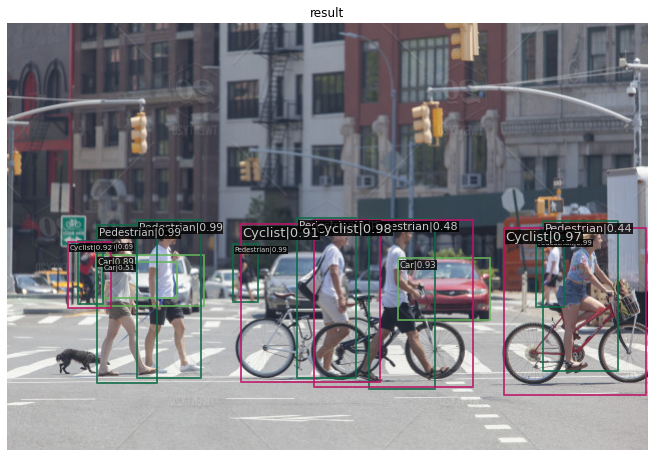

In [3]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# Choose to use a config and initialize the detector
# config = 'configs/resnet_strikes_back/faster_rcnn_r50_fpn_rsb-pretrain_1x_coco.py'
# base_cfg_path base_checkpoint
base_cfg_path = "./configs/resnet_strikes_back/faster_rcnn_r50_fpn_rsb-pretrain_1x_coco.py"
base_checkpoint = "./strikes_back/latest.pth"
from mmcv import Config
cfg = Config.fromfile(base_cfg_path)

cfg.model.roi_head.bbox_head.num_classes = 3
# Setup a checkpoint file to load
# checkpoint = 'new_dataset/latest.pth'
# initialize the detector
model = init_detector(cfg, base_checkpoint, device='cuda:0')

# from mmdet.apis import inference_detector, show_result_pyplot
# #, init_detector
# import mmcv

# img = mmcv.imread('kitti_full/training/image_2/000021.png')
img = 'images/t.png'
result = inference_detector(model, img)
# model.cfg = cfg
# result = inference_detector(model, img)
# show_result_pyplot(model, img, result)
show_result_pyplot(model, img, result)

In [4]:
import sys
sys.path.insert(0, './KalmanFilter')

In [6]:
import cv2
import numpy as np
import random
FONT = cv2.FONT_HERSHEY_SIMPLEX
from mmdet.apis import inference_detector


from KalmanFilter.kalmanFilter import KalmanFilter


model.cfg = cfg
TTL = 60
STABLED = 55

def threshold(x):
    return x[4] >= 0.5

def draw_text(img, text,
          font=FONT,
          pos=(0, 0),
          font_scale=0.4,
          font_thickness=1,
          text_color=(220,220,220),
          text_color_bg=(0, 0, 0)
          ):
    pos = pos[0] + 2, pos[1] + 2
    x, y = pos
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_w, text_h = text_size
    cv2.rectangle(img, pos, (x + text_w + 4, y + text_h + 4), text_color_bg, -1)
    cv2.putText(img, text, (x + 2, int(y + text_h + font_scale + 1)), font, font_scale, text_color, font_thickness)

    return text_size

def rectangle_area(tl_x, tl_y, br_x, br_y):
    return (br_x - tl_x) * (br_y - tl_y)

def iou(box1_tl, box1_br, box2_tl, box2_br):
    
    # print(box1_tl, box1_br)
    # print(box2_tl, box2_br)
    
    tl_x = max(box1_tl[0], box2_tl[0])
    tl_y = max(box1_tl[1], box2_tl[1])
    br_x = min(box1_br[0], box2_br[0])
    br_y = min(box1_br[1], box2_br[1])
    # print(tl_x, tl_y, br_x, br_y)
    
    
    # print(box1_area, box2_area, intersect_area)
    if tl_x < br_x and tl_y < br_y:
        intersect_area = rectangle_area(tl_x, tl_y, br_x, br_y)
    
        # box1_area = (box1_br[0] - box1_tl[0]) * (box1_br[1] - box1_tl[1])
        box1_area = rectangle_area(*box1_br, *box1_tl)
        # box2_area = (box2_br[0] - box2_tl[0]) * (box2_br[1] - box2_tl[1])
        box2_area = rectangle_area(*box2_br, *box2_tl)
        return intersect_area / (box1_area + box2_area - intersect_area)
    else:
        return 0
    # print(iou, intersect_area)
    # box1 = torch.tensor([[box1_tl[0], box1_tl[1], box2_tl[0], box2_br[1]]], dtype=torch.float)
    # box2 = torch.tensor([[544, 59, 610, 94]], dtype=torch.float)
    # iou = bops.box_iou(box1, box2)
    
    # return iou
    
    
OBJECT_ID = 0
CLASSES = ('Car', 'Pedestrian', 'Cyclist')
# RANGES = ((150, 220), (10, 100), (10, 100)), ((100, 150), (100, 150), (100, 150)), ((10, 100), (150, 200), (10, 150))
# RANGES = ((239, 220), (10, 90), (10, 100)), ((100, 170), (100, 190), (100, 190)), ((10, 80), (110, 200), (10, 100))
# RANGES = ((83, 196), (83, 191), (238, 238)), ((238, 238), (114, 212), (83, 83)), ((83, 129), (238, 238), (83, 217))
RANGES = ((238, 239), (83, 192), (83, 197)), ((83, 84), (114, 213), (238, 239)), ((83, 218), (238, 239), (83, 130))

# POINT_COLORS = ((0, 255, 0), (255, 0, 0), (0, 0, 255))

# def new_object(colors, mid_pt):
def new_object(colors):
    global OBJECT_ID
    OBJECT_ID += 1
    kf = KalmanFilter(0, method="Accerelation")
    # print(kf)
    kf.predict()
    # kf.correct(np.array(mid_pt))
    return (random.randrange(*colors[0]), random.randrange(*colors[1]), random.randrange(*colors[2])), OBJECT_ID, kf
    
def mid_point(x, y):
    return (x+y)/2

def traslate(old_tl, old_br, predict_mid):
    
    # print(old_tl, old_br, predict_mid)
    width = old_br[0] - old_tl[0]
    width/=2
    height = old_br[1] - old_tl[1]
    height/=2
    x, y = predict_mid
    return (int(x - width), int(y - height)), (int(x + width), int(y + height))
    
        
def draw_rectangles(frame, bboxes, i, previous_bboxes, colors):
    class_name = CLASSES[i]
    
    new_bboxes = []
    centers = []
    
    visited_previous_index_set = set()
    prev2new = {}
    matched_box = [[] for _ in range(len(previous_bboxes))]
    mutilple_matched_index = []
    
    predicted_bboxes = [traslate(pb[0], pb[1], pb[5].predict()) for pb in previous_bboxes]
    
    bboxes_no = 0
    
    for bboxes_index, (bbox_x1, bbox_y1, bbox_x2, bbox_y2, score) in enumerate(bboxes):
        bboxes_no += 1
        bbox_x1, bbox_y1, bbox_x2, bbox_y2 = int(bbox_x1), int(bbox_y1), int(bbox_x2), int(bbox_y2)
        
        matched_bbox_color, matched_id, matched_index = None, None, None
        threshold = 0.5
        for previous_index, p_box in enumerate(previous_bboxes):
            # current_iou = iou((bbox_x1, bbox_y1), (bbox_x2, bbox_y2), p_box[0], p_box[1])
            if p_box[6] < STABLED:
                pred_bboxes = predicted_bboxes[previous_index]
                current_iou = iou((bbox_x1, bbox_y1), (bbox_x2, bbox_y2), pred_bboxes[0], pred_bboxes[1])
                if current_iou > threshold:
                    threshold = current_iou
                    matched_bbox_color = p_box[3]
                    matched_id = p_box[4]
                    matched_index = previous_index
                    kf = p_box[5]
                
        if threshold == 0.5:
            for previous_index, p_box in enumerate(previous_bboxes):
                current_iou = iou((bbox_x1, bbox_y1), (bbox_x2, bbox_y2), p_box[0], p_box[1])

                # pred_bboxes = predicted_bboxes[previous_index]
                if current_iou > threshold:
                    threshold = current_iou
                    matched_bbox_color = p_box[3]
                    matched_id = p_box[4]
                    matched_index = previous_index
                    kf = p_box[5]
        
        if matched_bbox_color:
            color = matched_bbox_color
            obj_id = matched_id
            if len(matched_box[matched_index]) == 1:
                mutilple_matched_index.append(matched_index)
                print(matched_box[matched_index], bboxes_index)
            matched_box[matched_index].append(bboxes_index)
            visited_previous_index_set.add(matched_index)
            prev2new[matched_index] = len(new_bboxes)  # bboxes_index
        else:
            # color, obj_id, kf = new_object(colors, [mid_point(bbox_x1, bbox_x2), mid_point(bbox_y1, bbox_y2)])
            color, obj_id, kf = new_object(colors)
        new_bboxes.append([(bbox_x1, bbox_y1), (bbox_x2, bbox_y2), score, color, obj_id, kf])
        # centers.append([mid_point(bbox_x1, bbox_x2), mid_point(bbox_y1, bbox_y2)])
        

    for target_previous_index in mutilple_matched_index:
        print("Have multiple")
        multiple_bboxes = matched_box[target_previous_index]
        best_match_index, smallest_area_ratio_diff = None, None
        
        bbox_in_pre_frame = previous_bboxes[target_previous_index]
        p_box = predicted_bboxes[target_previous_index]
        pre_frame_area = rectangle_area(*p_box[0], *p_box[1])
        
        for i, new_bboxes_index in enumerate(multiple_bboxes):
            this_box = new_bboxes[new_bboxes_index]
            this_area = rectangle_area(*this_box[0], *this_box[1])
            area_ratio = this_area/ pre_frame_area
            this_diff = abs(1 - area_ratio)
            if smallest_area_ratio_diff is None or this_diff < smallest_area_ratio_diff:
                smallest_area_ratio_diff = this_diff
                best_match_index = i
        print(multiple_bboxes)
        print("Best", best_match_index)
        for i, new_bboxes_index in enumerate(multiple_bboxes):
            if i != best_match_index:
                print(i)
                box_to_be_corrected = new_bboxes[new_bboxes_index]
                # new_color, new_obj_id, kf = new_object(colors, [mid_point(*box_to_be_corrected[0]), mid_point(*box_to_be_corrected[1])])
                new_color, new_obj_id, kf = new_object(colors)
                print(new_bboxes[new_bboxes_index][4])
                box_to_be_corrected[3] = new_color
                box_to_be_corrected[4] = new_obj_id
                print(new_bboxes[new_bboxes_index][4])
                box_to_be_corrected[5] = kf
            else:
                prev2new[target_previous_index] = new_bboxes_index
    # visited_previous_index_set = set()
    # prev2new = {}
    for i in range(len(previous_bboxes)):
        if i in visited_previous_index_set:
            (bbox_x1, bbox_y1), (bbox_x2, bbox_y2), score, color, obj_id, kf = new_bboxes[prev2new[i]]
            
            cv2.rectangle(frame, (bbox_x1, bbox_y1), (bbox_x2, bbox_y2), color , 2)
            # cv2.rectangle(frame, p_bbox[0], p_bbox[1], p_bbox[3] , 2)
            score = format(score, '.2f')
            draw_text(frame, f'{obj_id} {class_name} {score}', pos=(bbox_x1, bbox_y1))
            new_bboxes[prev2new[i]].append(TTL + 1)
        else:
            # print(new_bboxes[i])
            # new_bboxes[i].append(previous_bboxes[i][6] - 1)
            # previous_bboxes[i][6] -= 1
            
            # update true bboxes
            p_bbox = previous_bboxes[i]
            if p_bbox[6] < STABLED:
                p_bbox[:2] = traslate(p_bbox[0], p_bbox[1], p_bbox[5].predict())
            new_bboxes.append(p_bbox)
            
    for i in set(range(bboxes_no)) - set(prev2new[i] for i in prev2new):
        (bbox_x1, bbox_y1), (bbox_x2, bbox_y2), score, color, obj_id, kf = new_bboxes[i]
        cv2.rectangle(frame, (bbox_x1, bbox_y1), (bbox_x2, bbox_y2), color , 2)
        score = format(score, '.2f')
        draw_text(frame, f'{obj_id} {class_name} {score}', pos=(bbox_x1, bbox_y1))
        new_bboxes[i].append(TTL)
    
    # print(new_bboxes)
    
    remove_list = []
    for i, ((bbox_x1, bbox_y1), (bbox_x2, bbox_y2), score, color, obj_id, kf, ttl) in enumerate(new_bboxes):
        # cv2.rectangle(frame, (bbox_x1, bbox_y1), (bbox_x2, bbox_y2), color , 2)
        kf.correct(np.array([[mid_point(bbox_x1, bbox_x2)], [mid_point(bbox_y1, bbox_y2)]]))
        predicted = kf.predict()
        # cv2.rectangle(frame, *traslate((bbox_x1, bbox_y1), (bbox_x2, bbox_y2), predicted), (0, 0, 0) , 2)
        
        # draw_text(frame, f'{obj_id} {class_name} {score}', pos=(bbox_x1, bbox_y1))
        
        if new_bboxes[i][6] == 0:
            remove_list.insert(0, i)
        else:
            new_bboxes[i][6] -= 1
    
    for i in remove_list:
        del new_bboxes[i]
    
    return new_bboxes

FRAME = 0
v_no = "Driving Downtown - New York City 4K - USA"
video = f'demo/youtube/{v_no}.mp4'
mid_file = f'demo/mid/{v_no}.txt'
vid_capture = cv2.VideoCapture(video)
# KALMAN_TRACKER_LIST = []
# for i in range(3):
#     KALMAN_TRACKER_LIST.append(Tracker(150, 30, 3))
if (vid_capture.isOpened() == False):
    print("Error opening the video file")
else:
    fps = vid_capture.get(cv2.CAP_PROP_FPS)
    frame_width = vid_capture.get(3)
    frame_height = vid_capture.get(4)
    output_vid = cv2.VideoWriter(f'demo/latest{v_no}.mp4', 0x7634706d , fps, (int(frame_width), int(frame_height)))
    c = 0
    previous_frame = [[], [], []]
    while True:
        
        ret, frame = vid_capture.read()
        if ret == True:
            # cv2.imwrite(f"demo/out/{i}.jpg", frame)
            result = inference_detector(model, frame)
            # print(result)
            if isinstance(result, tuple):
                bbox_result, segm_result = result
                if isinstance(segm_result, tuple):
                    segm_result = segm_result[0]  # ms rcnn
            else:
                bbox_result, segm_result = result, None

            
            # print(previous_frame)
            for i in range(3):
                previous_frame[i] = draw_rectangles(frame, filter(threshold, bbox_result[i]), i, previous_frame[i], RANGES[i])
            
            # print(previous_frame)
            # cv2.imwrite(f"demo/out1/3c{c}.jpg", frame)
            output_vid.write(frame)
            
            c += 1
            
        else:
            break
    vid_capture.release()
    output_vid.release()
print("Ended")

[1] 4
Have multiple
[1, 4]
Best 1
0
10319
10324
[4] 7
Have multiple
[4, 7]
Best 1
0
10332
10342
[3] 6
Have multiple
[3, 6]
Best 0
1
10332
10345
[4] 5
Have multiple
[4, 5]
Best 1
0
10332
10347
[2] 3
Have multiple
[2, 3]
Best 0
1
10356
10360
[1] 7
Have multiple
[1, 7]
Best 1
0
10380
10387
[2] 6
Have multiple
[2, 6]
Best 0
1
10387
10388
[4] 5
Have multiple
[4, 5]
Best 0
1
10387
10389
[2] 6
Have multiple
[2, 6]
Best 0
1
10387
10392
[2] 4
Have multiple
[2, 4]
Best 0
1
10396
10397
[3] 4
Have multiple
[3, 4]
Best 0
1
10396
10398
[1] 4
Have multiple
[1, 4]
Best 1
0
10396
10400
[2] 4
Have multiple
[2, 4]
Best 0
1
10400
10402
[2] 4
Have multiple
[2, 4]
Best 0
1
10400
10403
[3] 6
Have multiple
[3, 6]
Best 0
1
10319
10406
[2] 3
Have multiple
[2, 3]
Best 0
1
10413
10416
[2] 3
Have multiple
[2, 3]
Best 0
1
10408
10426
[0] 3
Have multiple
[0, 3]
Best 1
0
10431
10439
[1] 3
Have multiple
[1, 3]
Best 1
0
10439
10445
[1] 3
Have multiple
[1, 3]
Best 1
0
10439
10447
[1] 3
Have multiple
[1, 3]
Best 1
0
1043

In [49]:
count = cv2.cuda.getCudaEnabledDeviceCount()
print(count)

0


In [ ]:
modelTrue
fourcc tag 0x7634706d/'mp4v' codec_id 000C
fourcc tag 0x31637661/'avc1' codec_id 001B
fourcc tag 0x33637661/'avc3' codec_id 001B
fourcc tag 0x31766568/'hev1' codec_id 00AD
fourcc tag 0x31637668/'hvc1' codec_id 00AD
fourcc tag 0x7634706d/'mp4v' codec_id 0002
fourcc tag 0x7634706d/'mp4v' codec_id 0001
fourcc tag 0x7634706d/'mp4v' codec_id 0007
fourcc tag 0x7634706d/'mp4v' codec_id 003D
fourcc tag 0x7634706d/'mp4v' codec_id 0058
fourcc tag 0x312d6376/'vc-1' codec_id 0046
fourcc tag 0x63617264/'drac' codec_id 0074
fourcc tag 0x7634706d/'mp4v' codec_id 00A3
fourcc tag 0x39307076/'vp09' codec_id 00A7
fourcc tag 0x31307661/'av01' codec_id 801D
fourcc tag 0x6134706d/'mp4a' codec_id 15002
fourcc tag 0x63616c61/'alac' codec_id 15010
fourcc tag 0x6134706d/'mp4a' codec_id 1502D
fourcc tag 0x6134706d/'mp4a' codec_id 15001
fourcc tag 0x6134706d/'mp4a' codec_id 15000
fourcc tag 0x332d6361/'ac-3' codec_id 15003
fourcc tag 0x332d6365/'ec-3' codec_id 15028
fourcc tag 0x6134706d/'mp4a' codec_id 15004
fourcc tag 0x61706c6d/'mlpa' codec_id 1502C
fourcc tag 0x43614c66/'fLaC' codec_id 1500C
fourcc tag 0x7375704f/'Opus' codec_id 1503C
fourcc tag 0x6134706d/'mp4a' codec_id 15005
fourcc tag 0x6134706d/'mp4a' codec_id 15018
fourcc tag 0x6134706d/'mp4a' codec_id 15803
fourcc tag 0x7334706d/'mp4s' codec_id 17000
fourcc tag 0x67337874/'tx3g' codec_id 17005
fourcc tag 0x646d7067/'gpmd' codec_id 18807
fourcc tag 0x316d686d/'mhm1' codec_id 15817

In [73]:
cd ..

/userhome/cs/u3568315/Project/mmdetection


In [2]:
cd mmdetection

/userhome/cs/u3568315/Project/mmdetection


In [5]:
import sys
sys.path.insert(0, './KalmanFilter')

from KalmanFilter.tracker import Tracker
tTracker

In [6]:
tracker = Tracker(150, 30, 5)

In [ ]:
tracker